In [1]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob
from torch.optim.lr_scheduler import StepLR

In [1]:
def load_csvs(csv_paths):
    
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path)
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10] # discharge
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        df = df[df["Voltage"] <3.21] 
        df = df[df["Voltage"] >2.95]
        df["Charge_Capacity"] /= 1.1
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique()
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [3]:

def plot_cycles(data, cycles):
    print("plotting...")
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            try:
                time = time - time[0]
            except:
                print (time, voltage, "skipping")
                continue
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()
    

In [4]:
def fit_spline(data, cycles, no_points=500):
    i = 0
    
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Charge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            
            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage, k=1)

            # creating linear space 0, 200 of 20,000 points
            xi = np.linspace(0,700, 20000)
            yi_test = ius(xi)

            index_1 = np.argmin(np.abs(yi_test[:1000] - 3.2))
            index_2 = np.argmin(np.abs(yi_test - 3.0))

            indices = np.linspace(index_1, index_2, no_points).astype(int)

            #discarding points that are greater than time
#             xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
#             indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)
#             #selecting time at specified indices
            xi = xi[indices]
            yi = ius(xi)
            if yi[yi<2.998].any():
                continue
#                       
            ind = np.zeros_like(xi) + ind.values[0]
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append(np.array([xi, yi, capacity, ind]))
        cell_np = np.concatenate(cell_np, axis=1)
        cell_np = np.transpose(cell_np, (1,0))
        data[i] = pd.DataFrame(cell_np, columns = ['Step_Time', 'Voltage', 'Charge_Capacity', 'Cycle_Index'])
        i+=1
        
    return data

170
total points in ./Capacity_data/MIT/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (25333, 8)
plotting...


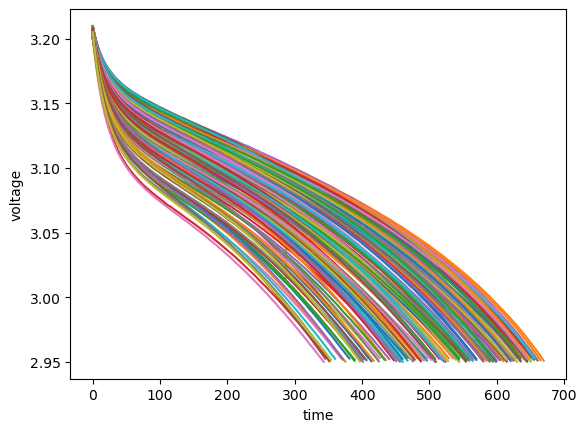

In [5]:
csvs = glob("./Capacity_data/MIT/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv")
csvs, cycles = load_csvs(csvs)
plot_cycles(csvs, cycles)


plotting...


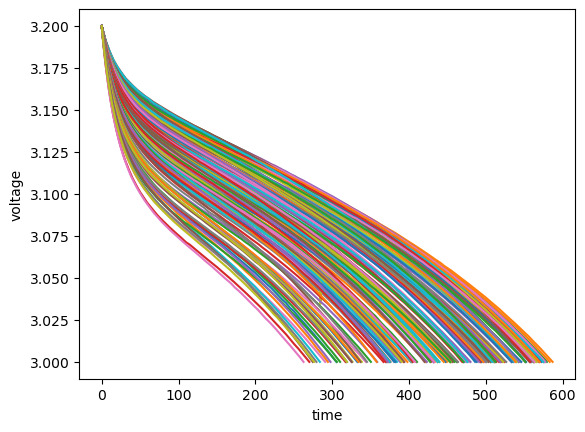

In [6]:
data = fit_spline(csvs.copy(), cycles, no_points=500)
plot_cycles(data, cycles)

In [5]:
transfer_learning_cycles = 100
train_data = [d[d.Cycle_Index < transfer_learning_cycles] for d in data]
test_data = [d[d.Cycle_Index >= transfer_learning_cycles] for d in data]
train_cycles = [cycle[cycle < transfer_learning_cycles] for cycle in cycles]
test_cycles = [cycle[cycle >= transfer_learning_cycles] for cycle in cycles]


NameError: name 'data' is not defined

In [9]:
import torch.nn as nn
import torch.nn.functional as F


    
# creating a four layer neural network.
# number of elements in input layer = segment length x 2
# 2 hidden layers each with two hundred units

    
# Neural Net to predict capacity
class CapacityNet(nn.Module):
    def __init__(self):
        super(CapacityNet, self).__init__()

        self.l1 = nn.Linear(in_features= int(500 * 2), out_features=400)
        self.l2 = nn.Linear(in_features=400, out_features=400)
        self.l3 = nn.Linear(in_features=400, out_features=400)
        self.l4 = nn.Linear(in_features=400, out_features=200)
        self.l5 = nn.Linear(in_features=200, out_features=100)
        self.l6 = nn.Linear(in_features=100, out_features=1)
#         self.l6_new = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        return self.l6(x)

    
    

In [10]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from bisect import bisect
  

# procesing data to get samples for training and testing
    
class CapacityDataset(Dataset):
    def __init__(self, data, type="train"):
        self.cycles = []

        for d in data:
            self.cycles.append(d.Cycle_Index.unique())
        self.data = data
#         self.window = window
        # cycles per cell
        self.spc = [cycle.shape[0] for cycle in  self.cycles]
        
    def __len__(self):
        return sum(self.spc)

    def __getitem__(self, idx):
        
        # the next three lines are locating the index in cycles of a particular cell
        
        cumsum = np.cumsum(self.spc)
        cell_no = bisect(cumsum, idx)
        ind = idx if cell_no == 0 else idx - cumsum[cell_no - 1]
        
        # picking the value of time, voltage, and capacity for the specified cycle during training or testing
        
        time_step = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Step_Time.values
        voltage = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Voltage.values
        capacity = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Charge_Capacity.max()
        
        # choosing a segment of specified length from the discharge curve for training or testing
        # if random = True, the segment will start anywhere from start of curve to 400- length of segment
#         print (time_step.shape, voltage.shape, cell_no, ind, capacity )

#         segment_length = np.random.randint(self.window[0], self.window[1])
#         start = 0 if not self.random else np.random.randint(0, 400 - segment_length)
#         time_x = time_step[start: start+segment_length]
#         voltage_x = voltage[start: start+segment_length]
        # creating input / feature vector (segment length x2)
        # the vector has voltage values followed by the corresponding time values
#         x = np.zeros((voltage_x.shape[0]*2))
        x = np.zeros((voltage.shape[0]*2))
#         max_segment = np.zeros((self.max_points * 2)) 
        x[::2] = voltage
        x[1::2] = time_step / 100
#         x_random_seg = np.zeros(((self.window[1] - 1) * 2))
#         x_random_seg[:x.shape[0]] = x

#         max_segment[:x.shape[0]] = x


        return x , torch.from_numpy(np.array([capacity]))




In [11]:
# train_voltage_c = CapacityDataset(train_data[:4],)
# train_loader_c = DataLoader(train_voltage_c, batch_size=64, shuffle=True)
# i=0
# for x, _ in train_loader_c:
#     print(i)
#     for curve in x:
#         time = curve[1::2]
#         voltage = curve[::2]
#         plt.plot(time, voltage)
#     i+=1
# plt.show()

In [13]:
train_voltage_c = CapacityDataset(train_data)
train_loader_c = DataLoader(train_voltage_c, batch_size=64, shuffle=True)

valid_voltage_c = CapacityDataset([test_data[0]])
valid_loader_c = DataLoader(valid_voltage_c, batch_size=64, shuffle=False)

test_mit = CapacityDataset([test_data[0]])
test_loader_mit = DataLoader(test_mit, batch_size=64, shuffle=False)

# Net to predict Capacity
net =  CapacityNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00041)
criteria = torch.nn.MSELoss() 
scheduler = StepLR(optimizer, step_size=4, gamma=0.99)

### Load Weights and freeze first 5 layers

In [14]:
net.load_state_dict(torch.load("./pretraining.pt"), strict=False)

# for name, param in net.named_parameters():
#     if  "l5" not in name and "l6" not in name:
#         param.requires_grad=False
#         pass

# for name, param in net.named_parameters():
#     print(name, param.requires_grad)

<All keys matched successfully>

In [15]:



def train(net, best, train_set, test_set, optimizer, criteria, epoch, best_mape):
    for dset, mode in [(train_set, 'train'), (test_set, 'test')]: # looping over two dataloaders (train and test)
        if mode == "test":
            net.eval() # if testing, don't compute gradients 
        else:
            net.train()
        loss = 0
        preds = []
        target = []
        for ind, (x, y) in enumerate(dset): # looping over dataloader (train or test)
            x = x.float()  #converting datatype to float, data type of inputs must match the datatype of weights of network
            y = y.float()

            pred = net(x) # neural net forward is called with input x. it will return capacity
            loss = criteria(pred, y) # computing mean square error between predicted capacity and target capacity
#             print (mode)
            if mode == "test":
                preds.extend(pred.detach().numpy().reshape(-1)) # if test dataloader, save the predictions for further analysis
                target.extend(y.cpu().numpy())
            if mode == 'train':
                optimizer.zero_grad() # if train mode, if there are any gradients from previous time step, set them to 0
                loss.backward()  # back propagation
                optimizer.step() # updating the weights
            loss += loss.item()  # converting loss(pytorch tensor) to python object and adding the value to total loss
    
    mape =  mean_absolute_percentage_error(preds, target) # computing the error of epoch
    if mape < best_mape and mode == "test":
        best = copy.deepcopy(net) #if error is less than the best error observed so far. save the model
        best_mape = mape # current error is the least error so for. so setting it as the best mape
    print (f'Mode: {mode} __ Epoch: {epoch} __ Loss: {loss/len(dset)}, mape: {mape}, Best Mape: {best_mape}')
    return net, best, best_mape # return the trained net
    

In [16]:
best_mape=4
best=None
for epoch in range(60):
    net, best, best_mape = train(net, best, train_loader_c, valid_loader_c, optimizer, criteria, epoch, best_mape)
    print (f'Learning rate {scheduler.get_last_lr()}')
    scheduler.step()
    
# save ./weights/

Mode: test __ Epoch: 0 __ Loss: 0.004942145198583603, mape: 0.06600473076105118, Best Mape: 0.06600473076105118
Learning rate [0.00041]
Mode: test __ Epoch: 1 __ Loss: 0.013463012874126434, mape: 0.20340409874916077, Best Mape: 0.06600473076105118
Learning rate [0.00041]
Mode: test __ Epoch: 2 __ Loss: 0.00955849327147007, mape: 0.16666415333747864, Best Mape: 0.06600473076105118
Learning rate [0.00041]
Mode: test __ Epoch: 3 __ Loss: 0.0003569967520888895, mape: 0.013034854084253311, Best Mape: 0.013034854084253311
Learning rate [0.00041]
Mode: test __ Epoch: 4 __ Loss: 0.014943157322704792, mape: 0.12647274136543274, Best Mape: 0.013034854084253311
Learning rate [0.0004059]
Mode: test __ Epoch: 5 __ Loss: 0.011024733074009418, mape: 0.10822075605392456, Best Mape: 0.013034854084253311
Learning rate [0.0004059]
Mode: test __ Epoch: 6 __ Loss: 0.0005753889563493431, mape: 0.016321679577231407, Best Mape: 0.013034854084253311
Learning rate [0.0004059]
Mode: test __ Epoch: 7 __ Loss: 0.0

Mode: test __ Epoch: 55 __ Loss: 0.0012230983702465892, mape: 0.027481310069561005, Best Mape: 0.011766939423978329
Learning rate [0.0003597836194295769]
Mode: test __ Epoch: 56 __ Loss: 0.0012370237382128835, mape: 0.02769608236849308, Best Mape: 0.011766939423978329
Learning rate [0.0003561857832352811]
Mode: test __ Epoch: 57 __ Loss: 0.0011835334589704871, mape: 0.02675359882414341, Best Mape: 0.011766939423978329
Learning rate [0.0003561857832352811]
Mode: test __ Epoch: 58 __ Loss: 0.0012063462054356933, mape: 0.02711648680269718, Best Mape: 0.011766939423978329
Learning rate [0.0003561857832352811]
Mode: test __ Epoch: 59 __ Loss: 0.00124353205319494, mape: 0.027728959918022156, Best Mape: 0.011766939423978329
Learning rate [0.0003561857832352811]


## Save Model

In [17]:
torch.save(best.state_dict(), "./finetuned.pt")

# Load Model

In [18]:
best_model = CapacityNet()
best_model.load_state_dict(torch.load("./finetuned.pt"))
best_model.eval()

CapacityNet(
  (l1): Linear(in_features=1000, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (l4): Linear(in_features=400, out_features=200, bias=True)
  (l5): Linear(in_features=200, out_features=100, bias=True)
  (l6): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
best_model = best

# Evaluate Performance 
# Val: (nasa cell 4 + mit cell 5)
# Test: (Mit cell 6)



 Valid MIT
(70,) (70,)
MAPE: 0.011766936720004206
RMSE : 0.00013747014152597177
R2 Score : 0.8224295409316333


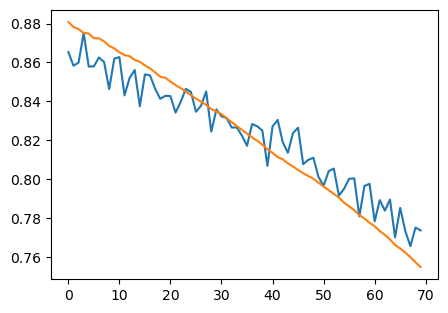



 TEST MIT
(70,) (70,)
MAPE: 0.011766936720004206
RMSE : 0.00013747014152597177
R2 Score : 0.8224295409316333


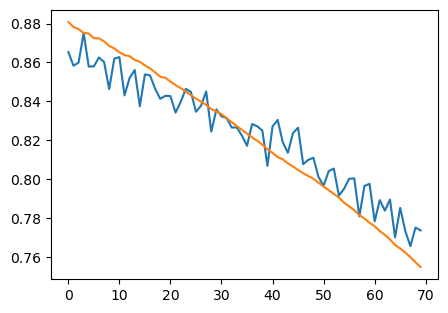

In [27]:
from sklearn.metrics import r2_score, mean_squared_error

# # Plot the capacity curve for cell 3 and predicted capacities for cell 3
# valid_nasa = CapacityDataset([nasa_data[3]], type='test', window=[25, 26], random=True)
# valid_mit = CapacityDataset([mit_data[4]], type='test', window=[25, 26],random=True)

# valid_loader_nasa = DataLoader(valid_nasa, batch_size=16,  shuffle=False)
# valid_loader_mit = DataLoader(valid_mit, batch_size=16, shuffle=False)

# test_mit = CapacityDataset([mit_data[5]], type='test', window=[25, 26], random=True)
# test_loader_mit = DataLoader(test_mit, batch_size=16, shuffle=False)


for loader, type in ([(valid_loader_c, "Valid MIT"), (test_loader_mit, "TEST MIT")]):
    print ("\n\n", type)
    preds = [best_model(x.float()) for x, _, in loader]
    y =  [x for _, x in loader]
    y = torch.cat(y).view(-1).detach().numpy()
    preds = torch.cat(preds).view(-1).detach().numpy()
    print (preds.shape, y.shape)
    plt.figure(figsize=(5, 3.5))
    plt.plot(np.arange(preds.shape[0]),preds)
    plt.plot(np.arange(preds.shape[0]),y)
    error_train_mape = mean_absolute_percentage_error(preds, y)
    error_train_rmse = mean_squared_error(preds, y)
    error_train_r2 = r2_score(preds, y)
    
    print(f"MAPE: {error_train_mape}" )
    print(f"RMSE : { error_train_rmse}")
    print(f"R2 Score : {error_train_r2}")
    
   
    
    plt.show()